# In-Context Learning with Transformers

This notebook demonstrates the concept of in-context learning by training a simplified Transformer model to predict outputs of linear functions based on input-output pairs provided in a prompt. We will use PyTorch to implement a basic Transformer and apply it to function classes like linear functions.

In [24]:
# Import statements
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [25]:
# Define a simple Transformer model
class SimpleTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers):
        super(SimpleTransformer, self).__init__()
        
        # Add a linear layer to project input_dim to model_dim
        self.embedding = nn.Linear(input_dim, model_dim)
        
        # Define the Transformer Encoder
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        
        # Output layer for scalar prediction
        self.fc = nn.Linear(model_dim, 1)

    def forward(self, src):
        # Project input data to the Transformer embedding space
        src = self.embedding(src)
        
        # Feed into the Transformer
        transformed = self.transformer(src)
        
        # Use the last sequence element (query) for the final output
        output = self.fc(transformed[-1])
        return output

In [26]:
# Generate linear function synthetic data
def generate_linear_data(batch_size, input_dim):
    """
    Generates random linear functions and corresponding input-output pairs.
    Returns in-context examples (x, y) and a query point x_query.
    """
    w = np.random.randn(batch_size, input_dim)  # Random weight vector for linear function
    x_in_context = np.random.randn(batch_size, input_dim)  # Input for in-context examples
    y_in_context = np.sum(w * x_in_context, axis=1, keepdims=True)

    x_query = np.random.randn(batch_size, input_dim)
    y_query = np.sum(w * x_query, axis=1, keepdims=True)
    return x_in_context, y_in_context, x_query, y_query

In [27]:
# Define training loop
def train_model(model, optimizer, loss_fn, num_epochs, batch_size, input_dim):
    losses = []  # To store loss after every epoch
    for epoch in range(num_epochs):
        model.train()

        # Generate training data
        x_in_context, y_in_context, x_query, y_query = generate_linear_data(batch_size, input_dim)

        # Convert numpy arrays to PyTorch tensors
        x_in_context = torch.tensor(x_in_context, dtype=torch.float32).unsqueeze(0)
        y_in_context = torch.tensor(y_in_context, dtype=torch.float32).unsqueeze(0)
        x_query = torch.tensor(x_query, dtype=torch.float32).unsqueeze(0)
        y_query = torch.tensor(y_query, dtype=torch.float32).unsqueeze(0)

        # Create a "prompt" combining in-context examples and the query
        prompt = torch.cat((x_in_context, x_query), dim=0)

        # Forward pass through the model
        pred = model(prompt)

        # Compute loss
        loss = loss_fn(pred, y_query)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save loss
        losses.append(loss.item())

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
    
    return losses

In [28]:
# In-context learning at inference time
def perform_inference(model, batch_size, input_dim):
    model.eval()

    # Generate a new set of in-context examples and query
    x_in_context, y_in_context, x_query, y_query = generate_linear_data(batch_size, input_dim)

    # Convert data to tensors
    x_in_context = torch.tensor(x_in_context, dtype=torch.float32).unsqueeze(0)
    x_query = torch.tensor(x_query, dtype=torch.float32).unsqueeze(0)

    # Create prompt: (in-context examples + query)
    prompt = torch.cat((x_in_context, x_query), dim=0)

    # Forward pass through the model
    with torch.no_grad():
        pred = model(prompt)

    # Print predicted vs true values
    print(f"Predicted output: {pred.flatten().numpy()}")
    print(f"True output: {y_query.flatten()}")

    # Visualization: Plot predicted vs true outputs
    plt.figure(figsize=(8, 6))
    plt.scatter(y_query.flatten(), pred.flatten().numpy(), color="blue")
    plt.plot([min(y_query), max(y_query)], [min(y_query), max(y_query)], color="red", linestyle="--")
    plt.title("Predicted vs True Outputs")
    plt.xlabel("True Outputs")
    plt.ylabel("Predicted Outputs")
    plt.grid(True)
    plt.show()

In [29]:
# Model parameters
input_dim = 5  # Dimensionality of input
model_dim = 16  # Internal model size
num_heads = 2  # Number of attention heads
num_layers = 2  # Number of Transformer layers
batch_size = 32
num_epochs = 5000

# Initialize model, loss function, and optimizer
model = SimpleTransformer(input_dim, model_dim, num_heads, num_layers)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Train the model
train_model(model, optimizer, loss_fn, num_epochs, batch_size, input_dim)

Epoch 100/5000, Loss: 3.232585906982422
Epoch 200/5000, Loss: 3.920377254486084
Epoch 300/5000, Loss: 7.521198272705078
Epoch 400/5000, Loss: 4.258418560028076
Epoch 500/5000, Loss: 3.9115700721740723
Epoch 600/5000, Loss: 6.331277847290039
Epoch 700/5000, Loss: 5.801437854766846
Epoch 800/5000, Loss: 3.551520347595215
Epoch 900/5000, Loss: 4.95584774017334
Epoch 1000/5000, Loss: 5.669355392456055
Epoch 1100/5000, Loss: 2.933072328567505
Epoch 1200/5000, Loss: 4.453614711761475
Epoch 1300/5000, Loss: 5.189144611358643
Epoch 1400/5000, Loss: 4.577207565307617
Epoch 1500/5000, Loss: 5.9829206466674805
Epoch 1600/5000, Loss: 3.6956117153167725
Epoch 1700/5000, Loss: 3.0194077491760254
Epoch 1800/5000, Loss: 11.734560012817383
Epoch 1900/5000, Loss: 4.304238319396973
Epoch 2000/5000, Loss: 3.595296859741211
Epoch 2100/5000, Loss: 5.773401260375977
Epoch 2200/5000, Loss: 4.59104061126709
Epoch 2300/5000, Loss: 8.676911354064941
Epoch 2400/5000, Loss: 4.218286991119385
Epoch 2500/5000, Loss:

[1.991243600845337,
 5.983285903930664,
 4.395655155181885,
 5.275013446807861,
 4.835460662841797,
 8.52356243133545,
 5.530510425567627,
 5.358834266662598,
 4.3320159912109375,
 6.076852321624756,
 7.0314836502075195,
 2.9413280487060547,
 3.3971121311187744,
 4.862082004547119,
 6.145498275756836,
 5.4513750076293945,
 6.6618242263793945,
 3.999514102935791,
 4.463988780975342,
 6.005114555358887,
 6.134190082550049,
 4.311128616333008,
 2.5936806201934814,
 4.88792610168457,
 3.6682052612304688,
 4.300386905670166,
 3.2133305072784424,
 4.134288787841797,
 5.23209285736084,
 1.6446248292922974,
 3.1175594329833984,
 4.112946510314941,
 4.889376163482666,
 3.9325637817382812,
 4.838221073150635,
 4.631444454193115,
 4.6271071434021,
 4.73683500289917,
 4.311566352844238,
 4.469660758972168,
 4.296923637390137,
 4.731685161590576,
 7.815251350402832,
 7.5223917961120605,
 3.587488889694214,
 5.197729110717773,
 6.955996036529541,
 4.4748454093933105,
 4.66134786605835,
 3.6709365844

Predicted output: [0.0239015  0.02431398 0.02416858 0.02394876 0.0235886  0.02378174
 0.02437679 0.02442998 0.0239292  0.02437753]
True output: [ 0.88570364 -0.77011977 -0.28804887 -4.69325994 -0.84427315  0.38482736
 -3.31664344  2.90046245  2.61745791  0.46182109]


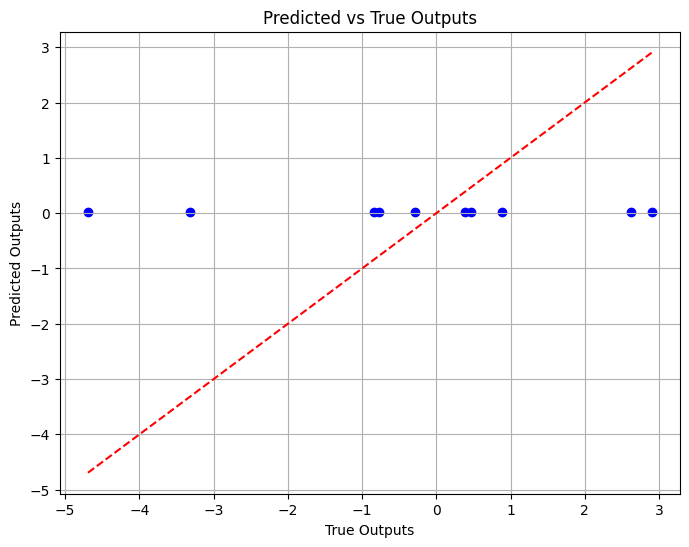

In [30]:
# Perform inference
perform_inference(model, batch_size=10, input_dim=input_dim)

Epoch 100/5000, Loss: 3.60903263092041
Epoch 200/5000, Loss: 5.207348346710205
Epoch 300/5000, Loss: 7.3422770500183105
Epoch 400/5000, Loss: 4.0111565589904785
Epoch 500/5000, Loss: 3.986661672592163
Epoch 600/5000, Loss: 5.3174028396606445
Epoch 700/5000, Loss: 4.107448101043701
Epoch 800/5000, Loss: 3.129997968673706
Epoch 900/5000, Loss: 4.929921627044678
Epoch 1000/5000, Loss: 5.659837245941162
Epoch 1100/5000, Loss: 5.650320529937744
Epoch 1200/5000, Loss: 6.153899192810059
Epoch 1300/5000, Loss: 8.834014892578125
Epoch 1400/5000, Loss: 7.320240020751953
Epoch 1500/5000, Loss: 5.188121795654297
Epoch 1600/5000, Loss: 3.8002171516418457
Epoch 1700/5000, Loss: 4.699186325073242
Epoch 1800/5000, Loss: 4.943267345428467
Epoch 1900/5000, Loss: 5.661398887634277
Epoch 2000/5000, Loss: 5.023329257965088
Epoch 2100/5000, Loss: 4.945773601531982
Epoch 2200/5000, Loss: 3.7242140769958496
Epoch 2300/5000, Loss: 2.9489173889160156
Epoch 2400/5000, Loss: 4.90137243270874
Epoch 2500/5000, Loss

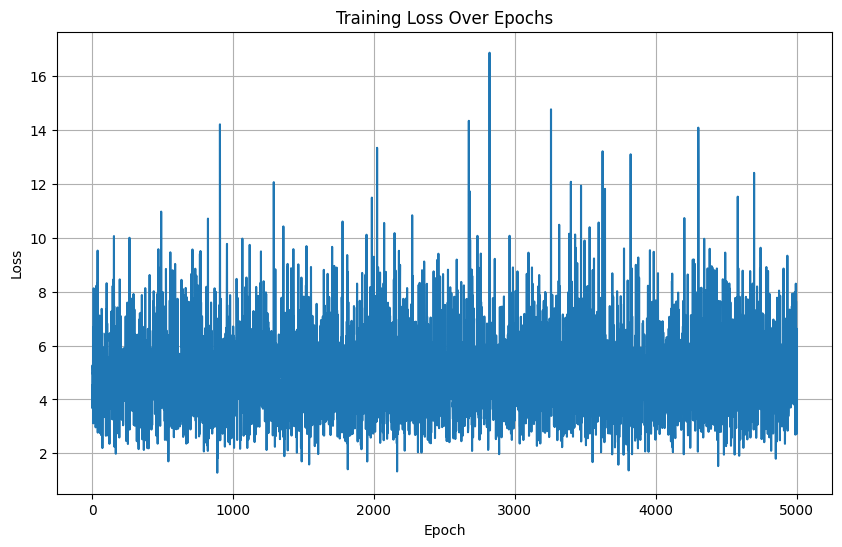

In [31]:
# Train the model and capture losses
losses = train_model(model, optimizer, loss_fn, num_epochs, batch_size, input_dim)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()